In [1]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='/tmp/Cora', name='Cora')

Se obtiene un conjunto de datos de planetoides y se guarda en la carpeta C:\tmp\Cora

In [2]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

Librerías para entrenar con Graph Convolutional Network

In [3]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

Se toman los datos para realizar dos capas de red neuronal. 
La primera capa toma los datos de las características o "features" y proporciona 16 características o "features" para la capa 2.
La segunda capa toma los datos de la primera y clasifica los planetoides según las etiquetas/clases.  

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
model.train()
x = []
y = []
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

Loss function value per iteration. 

torch.Size([2708, 7])
ROC AUC: 0.9225


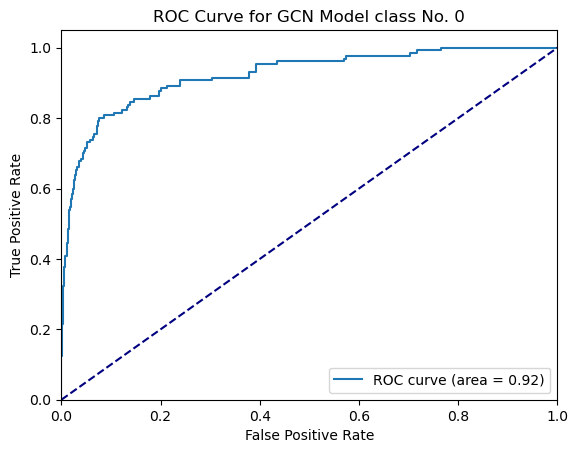

ROC AUC: 0.9700


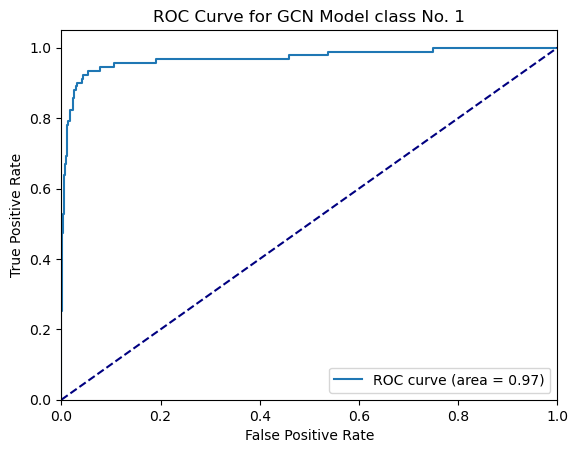

ROC AUC: 0.9862


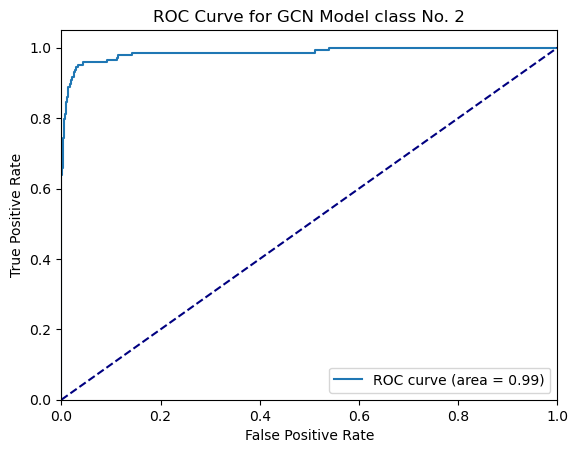

ROC AUC: 0.9548


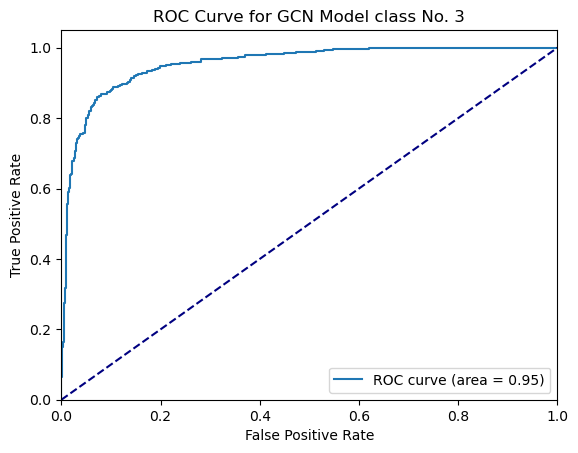

ROC AUC: 0.9672


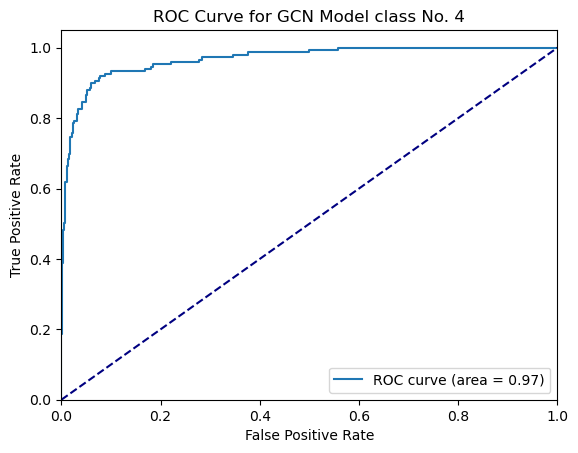

ROC AUC: 0.9517


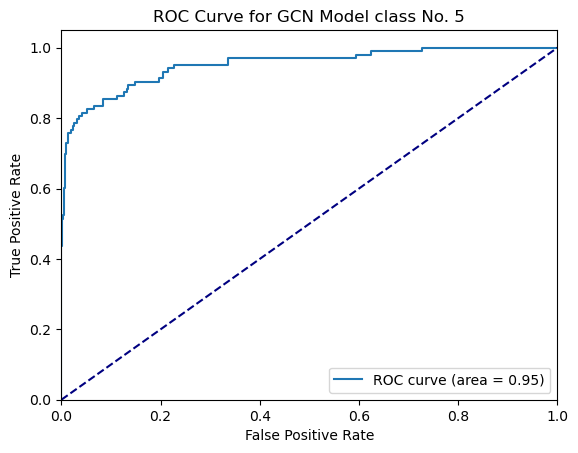

ROC AUC: 0.9684


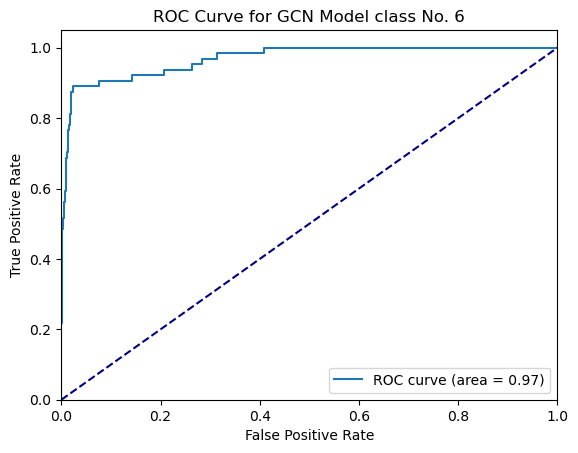

Accuracy: 0.8000


In [5]:
model.eval()
pred = model(data).argmax(dim=1)
output = model(data)
pred_prob = torch.exp(output)
print(pred_prob.shape)
for class_name in range(dataset.num_classes):
    class_prob = pred_prob[data.test_mask][:, class_name].tolist()
    condition_function = lambda x: bool(x == class_name )
    true_false = list(map(condition_function, data.y[data.test_mask]))
    fpr, tpr, thresholds = roc_curve(true_false, class_prob)
    roc_auc = auc(fpr, tpr)
    print(f'ROC AUC: {roc_auc:.4f}')

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for GCN Model class No. {class_name}')
    plt.legend(loc="lower right")
    plt.show()

correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')